# Parole Models: Initial data exploration, cleaning, & processing

### Willie Costello

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize']=(8.0, 6.0)
%config InlineBackend.figure_format='retina'

## Importing & cleaning data

In [2]:
df_raw = pd.read_csv('~/data/ParoleModels/data.csv')

In [3]:
df_raw.shape

(744958, 26)

In [4]:
# Check for duplicates
df_raw.duplicated().sum()

0

In [5]:
# Check for missing values
df_raw.isna().mean().sort_values()

FISCAL YEAR                     0.000000
WARRANT ID                      0.000000
LOCATION TYPE                   0.000000
PROVINCE                        0.000000
OFFENCE ID                      0.000000
SENTENCE TYPE                   0.000000
JURISDICTION                    0.000000
OFFENCE DESCRIPTION             0.000000
AGE                             0.000000
GENDER                          0.000000
RACE GROUPING                   0.000000
OFFENDER NUMBER                 0.000000
IN CUSTODY/COMMUNITY            0.000000
SENTENCE ID                     0.000000
AGGREGATE SENTENCE LENGTH       0.000008
COURT                           0.014460
RACE                            0.017673
STATIC/RISK                     0.029078
DYNAMIC/NEED                    0.029407
REINTEGRATION POTENTIAL         0.030132
MOTIVATION                      0.030594
OFFENDER SECURITY LEVEL         0.065860
RELIGION                        0.070193
INSTUTUTIONAL SECURITY LEVEL    0.317110
SUPERVISION TYPE

`JUDGE` column is 100% missing values, so we will drop it. We will also here drop `RACE GROUPING`, `RELIGION`, `COURT`, `LOCATION TYPE`, `WARRANT ID`, `OFFENCE ID`, and `SENTENCE ID` since we will not be making use of these data.

In [6]:
df_clean = df_raw.drop(['JUDGE', 'RACE GROUPING', 'RELIGION', 'COURT', 'LOCATION TYPE', 'WARRANT ID', 'OFFENCE ID', 'SENTENCE ID'], axis=1)

The `INSTUTUTIONAL (sic) SECURITY LEVEL` and `SUPERVISION TYPE` columns also have a high percentage of missing values, but they are complementary: records with missing `INSTITUTIONAL SECURITY LEVEL` values have a `SUPERVISION TYPE` value, and vice versa. This is because inmates without an institutional security level are no longer in custody but in the community, and thus have a supervision type, and inmates without a supervision type are not in the community but in custody, and thus have an institutional security level.

Here we will combine the data from these two columns in a new single column, `SECURITY/SUPERVISION`. The rows with missing values in this new column will then be dropped.

In [7]:
# Combine Institutional Security Level and Supervision Type values into single column
df_clean['SECURITY/SUPERVISION'] = df_clean['INSTUTUTIONAL SECURITY LEVEL'].fillna(df_clean['SUPERVISION TYPE'])

In [8]:
print(f"Number of remaining missing values: {df_clean['SECURITY/SUPERVISION'].isna().sum()} rows")

Number of remaining missing values: 1316 rows


In [9]:
# Drop remaining missing values
df_clean.dropna(subset=['SECURITY/SUPERVISION'], inplace=True)

# Drop Institutional Security Level, Supervision Type, and In Custody/Community columns
df_clean.drop(['INSTUTUTIONAL SECURITY LEVEL', 'SUPERVISION TYPE', 'IN CUSTODY/COMMUNITY'], axis=1, inplace=True)

Let's next convert the `FISCAL YEAR` column into something more descriptive.

In [10]:
df_clean['YEAR'] = df_clean['FISCAL YEAR'].apply(lambda x: '20' + x[-2:])

Let's now convert the `DETERMINATE SENTENCE` column into a binary column.

In [11]:
df_clean['DETERMINATE_SENTENCE'] = np.where(df_clean['SENTENCE TYPE']=='DETERMINATE', 1, 0)

In [12]:
# Round Offender Number to five decimal points, to fix some datatype issues
df_clean['OFFENDER ID'] = df_clean['OFFENDER NUMBER'].apply(lambda x: round(x, 5))

In [13]:
# Drop converted columns
df_clean.drop(['FISCAL YEAR', 'SENTENCE TYPE', 'OFFENDER NUMBER'], axis=1, inplace=True)

In [14]:
# Reformat column names
df_clean.columns = [x.lower().replace(' ', '_') for x in df_clean.columns]

In [15]:
df_clean.shape

(743642, 16)

In [16]:
df_clean.head()

,race,gender,age,jurisdiction,aggregate_sentence_length,province,offender_security_level,dynamic/need,static/risk,reintegration_potential,motivation,offence_description,security/supervision,year,determinate_sentence,offender_id
0,White,MALE,23,FEDERAL,1096.0,ONTARIO,MINIMUM,MEDIUM,LOW,HIGH,HIGH,POSS PROH/RESTR F/ARM W/AMMUN,MINIMUM,2012,1,82.50710
1,White,MALE,23,FEDERAL,1096.0,ONTARIO,MINIMUM,MEDIUM,LOW,HIGH,HIGH,FAIL TO COMPLY W/ PROBATION ORDER,MINIMUM,2012,1,82.50710
2,White,MALE,23,FEDERAL,1096.0,ONTARIO,MINIMUM,MEDIUM,LOW,HIGH,HIGH,POSS SCHEDULE I/II SUBST FOR PURP TRAFF,MINIMUM,2012,1,82.50710
3,White,MALE,39,FEDERAL,732.0,BRITISH COLUMBI,MEDIUM,HIGH,HIGH,LOW,MEDIUM,ASSAULT - USE OF FORCE,MEDIUM,2012,1,104.76347
4,White,MALE,39,FEDERAL,732.0,BRITISH COLUMBI,MEDIUM,HIGH,HIGH,LOW,MEDIUM,ROBBERY - ALL OTHERS,MEDIUM,2012,1,104.76347


Following the *Globe*'s analysis, we will only consider data from offenders serving a federal sentence, as indicated in the `jurisdiction` column. For the purposes of our analysis, we will also only consider data from male-identifying inmates, since they make up the vast majority of our data. We will also drop the `province` and `offender_security_level` columns, as they will not currently be figuring in our analysis.

In [17]:
df_filter = df_clean[(df_clean['jurisdiction']=='FEDERAL') & (df_clean['gender']=='MALE')].copy()
df_filter.drop(['jurisdiction', 'gender', 'province', 'offender_security_level'], axis=1, inplace=True)

In [18]:
# Create a copy of cleaned dataframe
df = df_filter.copy().reset_index(drop=True)

## Exploring column values

In [19]:
for col in df.select_dtypes(object).columns:
    print(f'Value counts for {col}\n')
    print(df[col].value_counts())
    print('\n-------------------------\n')

Value counts for race

White              462493
North American      87843
Black               49485
Metis               47124
S. E. Asian          5951
Inuit                5670
Arab/West Asian      5481
Latin American       5390
Arab                 3745
Multirac/Ethnic      3570
South Asian          2918
Other                2250
Asi-E/Southeast      2063
Chinese              1977
Filipino             1500
Asian-South          1292
Caribbean            1249
Unable Specify        789
Euro.-Eastern         754
Asiatic               633
Euro.-Southern        511
Sub-Sahara Afri       451
Korean                329
Euro.-Western         309
Asian-West            252
East Indian           208
Japanese              156
Hispanic              126
Oceania               120
Euro.-Northern         86
European French        81
British Isles          64
Unknown                54
Name: race, dtype: int64

-------------------------

Value counts for dynamic/need

HIGH      401872
MEDIUM    215624
L

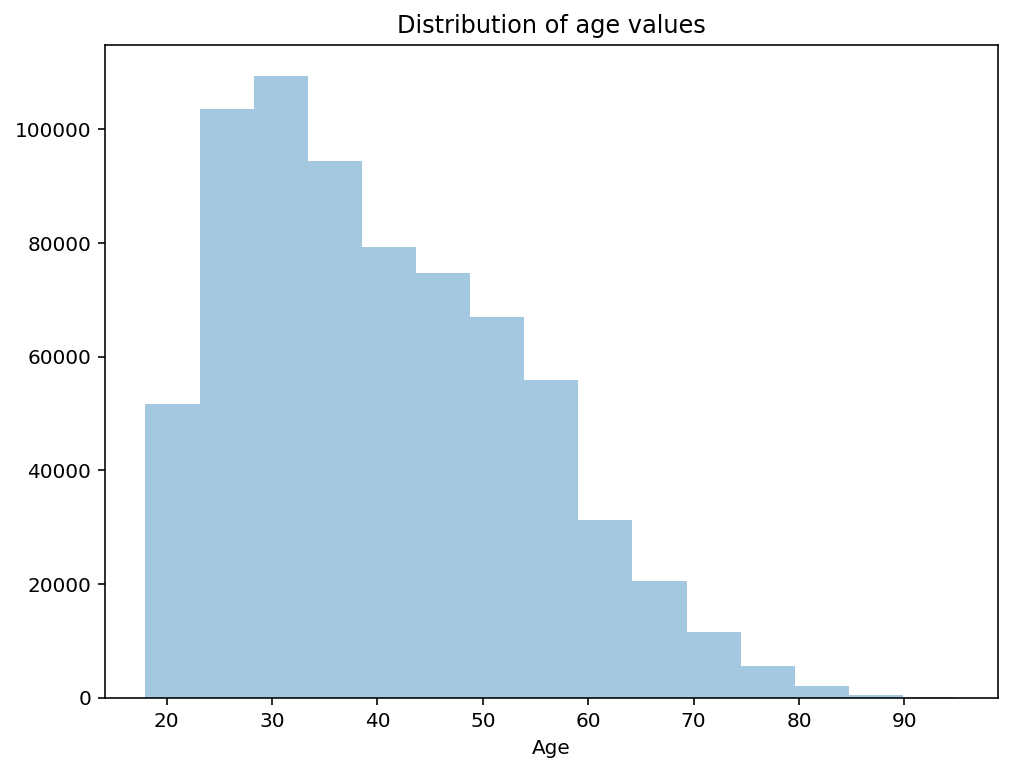

In [20]:
plt.figure()
sns.distplot(df['age'], bins=15, kde=False)
plt.xlabel('Age')
plt.title('Distribution of age values')
plt.show()

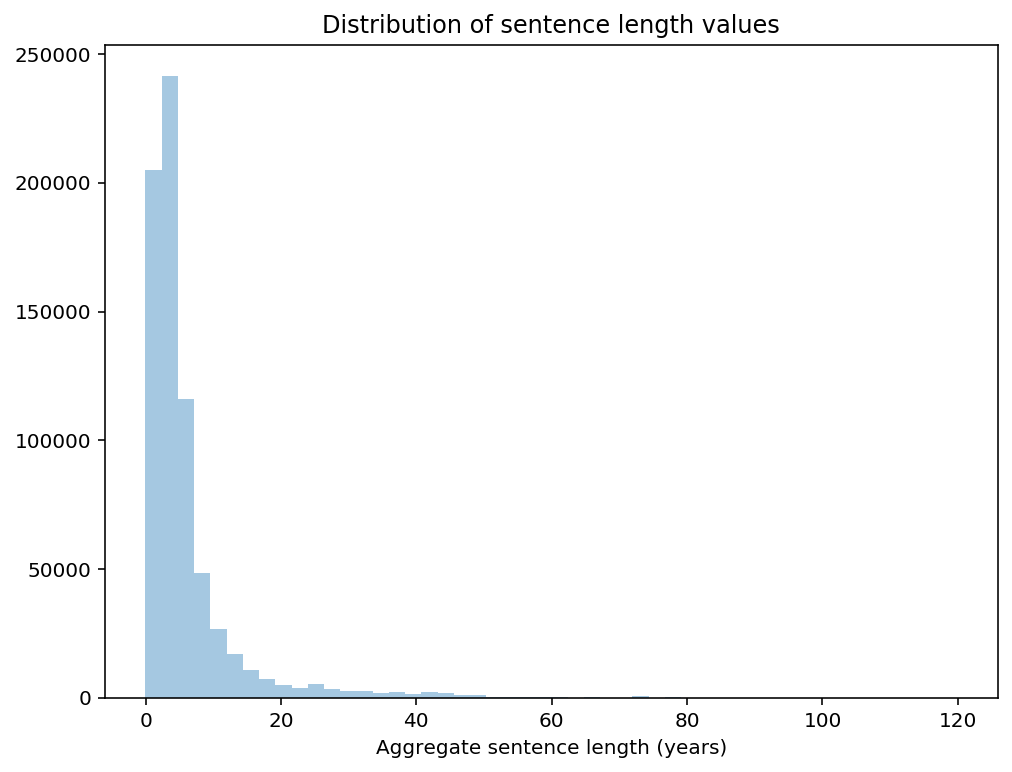

In [21]:
plt.figure()
sns.distplot(df['aggregate_sentence_length'] / 365, kde=False)
plt.xlabel('Aggregate sentence length (years)')
plt.title('Distribution of sentence length values')
plt.show()

## Consolidating race column

Following the *Globe*'s methodology, we will consolidate the 33 races in the `race` column into simpler groupings (such as Black, Indigenous, White and Latino), using [Ontario's Data Standards for the Identification and Monitoring of Systemic Racism](https://files.ontario.ca/solgen_data-standards-en.pdf). Since our analysis, like the *Globe*'s, is focused on the differences between White, Black and Indigenous inmates, we further consolidate other races into an "other" category.

In [22]:
race_dict = {'White':'White',
             'Euro.-Southern':'White', 
             'Euro.-Eastern':'White',
             'Euro.-Western':'White',
             'Euro.-Northern':'White',
             'British Isles':'White',
             'European French':'White',
             'Black':'Black',
             'Caribbean':'Black',
             'Sub-Sahara Afri':'Black',
             'North American':'Indigenous',
             'Metis':'Indigenous', 
             'Inuit':'Indigenous'}

In [23]:
df['race_group'] = df['race'].map(race_dict)

In [24]:
df['race_group'] = df['race_group'].fillna('Other')

In [25]:
race_dummies = pd.get_dummies(df['race_group'], prefix='race').drop('race_Other', axis=1)

In [26]:
df = pd.concat([df, race_dummies], axis=1).drop(['race', 'race_group'], axis=1)

## Transforming multilevel columns

In [27]:
# Loop through columns
for col in ['static/risk', 'dynamic/need', 'motivation']:

    # Lowercase column values
    df[col] = df[col].str.lower()
    
    # Dummify column, dropping first column
    col_dummies = pd.get_dummies(df[col], prefix=col).drop(f'{col}_medium', axis=1)
    
    # Add dummy columns to dataframe & remove original column
    df = pd.concat([df, col_dummies], axis=1).drop(col, axis=1)

In [28]:
# Similarly transform security/supervision column
df['security/supervision'] = df['security/supervision'].str.lower().str.replace(' ', '_')
secsup_dummies = pd.get_dummies(df['security/supervision'], prefix='sec/sup').drop(f'sec/sup_long_term_super', axis=1)
df = pd.concat([df, secsup_dummies], axis=1).drop('security/supervision', axis=1)

## Binning age & sentence length values

In [29]:
df['age_bin'] = pd.qcut(df['age'], 10)
df['sentence_bin'] = pd.qcut(df['aggregate_sentence_length'] / 365.25, 10)

In [30]:
age_dummies = pd.get_dummies(df['age_bin'], prefix='age')
sentence_dummies = pd.get_dummies(df['sentence_bin'], prefix='sentence')

In [31]:
df = pd.concat([df, age_dummies, sentence_dummies], axis=1).drop(['age', 'aggregate_sentence_length', 'age_bin', 'sentence_bin'], axis=1)

## Filtering to top offences

In [32]:
# Lowercase column values & replace whitespaces with underscores
df['offence_description'] = df['offence_description'].str.lower().str.replace(' ', '_')

In [33]:
# Get normalized value counts for all offence descriptions
offence_pcts = df['offence_description'].value_counts(normalize=True)

In [34]:
# Filter to offence descriptions that appear in more than 0.1% of the data
offence_pcts[offence_pcts > .001]

robbery_-_all_others                       0.050078
fail_to_comply_w/cond_of_under/recog       0.043932
break_enter_and_commit                     0.040450
poss_schedule_i/ii_subst_for_purp_traff    0.039668
fail_to_comply_w/_probation_order          0.035403
                                             ...   
production_of_sched_i/ii_subst             0.001042
prison_breach_with_intent                  0.001041
luring_a_child_u/18                        0.001038
procures/poss/sells_identity_document      0.001029
traffic_in_schedule_iii_substance          0.001010
Name: offence_description, Length: 137, dtype: float64

In [35]:
# Create a list of these top offences
top_offences = offence_pcts[offence_pcts > .001].index.tolist()

In [36]:
# Filter dataframe to only rows with one of these top offences
df_filtered = df[df['offence_description'].isin(top_offences)].reset_index(drop=True)

## Transforming data

In [37]:
# Dummify offence description column
offence_dummies = pd.get_dummies(df_filtered['offence_description'], prefix='offence')

There are two ways we may want to aggregate our dummified offence description columns: We can either record the inmate's total number of charges for each offence type, or we can simply record whether or not the inmate was charged with each offence type (regardless of the total number of charges). It's not clear to me which method will be better for modelling purposes, so I'll here do both.

In [38]:
# Select all columns other than Offence Description and Reintegration Potential (target variable)
df_others = df_filtered.drop(['offence_description', 'reintegration_potential'], axis=1)

In [39]:
# Group dataframe by Offender ID and year (i.e., one row for each unique reintegration potential assessment)
# All values are the same across each set of grouped rows, so taking the max will retrieve those values
df_others_grouped = df_others.groupby(['offender_id', 'year']).max()

In [40]:
# Create dataframe of dependent variable, similarly grouped
df_y_grouped = df_filtered.groupby(['offender_id', 'year'])['reintegration_potential'].max()

# Reset index
y = df_y_grouped.reset_index(drop=True)

### Summing strategy

In [41]:
# Add dummy columns to dataframe's Offender ID & year columns
df_off_dummies = pd.concat([df_filtered[['offender_id', 'year']], offence_dummies], axis=1)

# Group dataframe and take the sum
df_off_sum = df_off_dummies.groupby(['offender_id', 'year']).sum()

# Add summed dummy columns to others
df_X_sum = pd.concat([df_others_grouped, df_off_sum], axis=1)

# Reset index
X_sum = df_X_sum.reset_index(drop=True)

### Binary strategy

In [42]:
# Group dataframe and take the max
df_off_binary = df_off_dummies.groupby(['offender_id', 'year']).max()

# Add binary dummy columns to others
df_X_binary = pd.concat([df_others_grouped, df_off_binary], axis=1)

# Reset index
X_binary = df_X_binary.reset_index(drop=True)

In [43]:
# Write dataframes to file
X_sum.to_csv('~/data/ParoleModels/X_sum.csv', index=False)
X_binary.to_csv('~/data/ParoleModels/X_binary.csv', index=False)
y.to_csv('~/data/ParoleModels/y.csv', index=False)